# Implement plateau potential in Neuron model

In [21]:
%matplotlib inline

from    neuron  import          h
import  numpy                as np
import  matplotlib.pyplot    as plt
import  matplotlib.image     as mpimg
import  json

from mpl_toolkits.axes_grid.inset_locator import inset_axes


h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')
    

1.0

## Single cell default values (no leak)

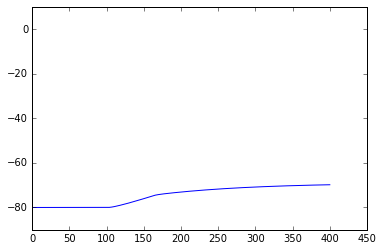

In [4]:
# simulation length
tstop = 400

# create cell
dend = h.Section(name='dend')

# add new receptors

# create synapse
x = 0.5
syn         = h.glutamate(x, sec=dend)
syn.ratio   = 1.0/3.0


# create NetStim object
stim            = h.NetStim()
stim.number     = 20
stim.start      = 100
stim.interval   = 1000/300 # mean interval between two spikes in ms (1000 / 300 Hz)
#stim.noise      = 1.0


#vecStim = h.VecStim()
#vec = h.Vector([100, 120])
#vecStim.play(vec)


# create NetCon object
#ncon             = h.NetCon(stim,syn) 
ncon             = h.NetCon(stim, syn)
ncon.delay       = 1
ncon.weight[0]   = 1.5e-3 # (uS) = 1.5 nS
#ncon.threshold   = 0.1

# record vectors
vm = h.Vector()
vm.record(dend(0.5)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)

h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.figure()   
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Adjust size of section (l=d=12.2 um)

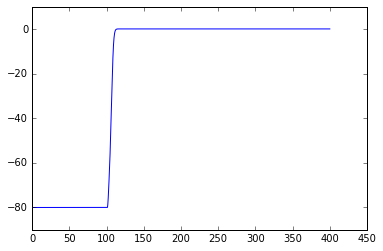

In [5]:

# UPDATED********************************************************
# size of dend
dend.L         = 12.2
dend(0.5).diam = 12.2
# ***************************************************************


h.finitialize(-80)
while h.t < tstop:
    h.fadvance()

plt.figure()
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### With leak

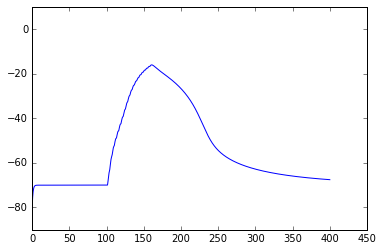

In [6]:


# UPDATED********************************************************
# insert pas
dend.insert('pas')
# ***************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Set (non default) values of leak

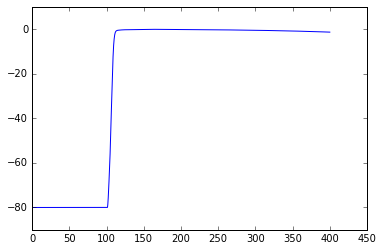

In [7]:


# UPDATED********************************************************
dend.g_pas = 1e-5
dend.e_pas = -80
dend.cm    = 1.0
dend.Ra    = 150
#****************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Weak synaptic activation (1 spine in the Genesis model)

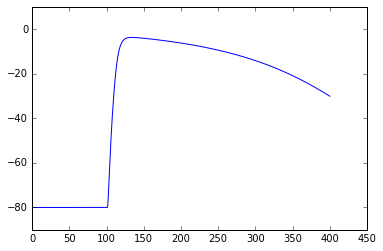

In [8]:


# max receptor current (uS)
# UPDATED********************************************************
stim.number     = 1
# ***************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### include ion channels (maximal conductance is same as at 115 um)

In [9]:
# calc channel gmax
def calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):
    '''
    Used for setting the maximal conductance of a segment.
    Scales the maximal conductance based on somatic distance and distribution type.
    
    Parameters:
    d3   = distribution type:
         0 linear, 
         1 sigmoidal, 
         2 exponential
         3 step function
    dist = somatic distance of segment
    a4-7 = distribution parameters 
    g8   = base conductance (similar to maximal conductance)
    
    '''
    
    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + np.exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*np.exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5
            
    if value < 0:
        value = 0
        
    value = value*g8
    return value

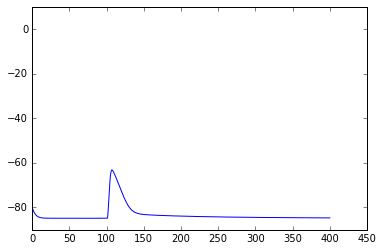

In [10]:


# UPDATED********************************************************
# insert ion channels
casc    =   h.D1_reduced_cascade2_0(0.5, sec=dend) 
pointer =   casc._ref_Target1p   

with open('params_dMSN.json') as file:
    par = json.load(file)

channels = [        "naf",      
                    "kaf",
                    "kas",
                    "kdr",
                    "kir",
                    "cal12",
                    "cal13",
                    "can",
                    "car",
                    "cav32",
                    "cav33",
                    "sk",
                    "bk"            ]

for mech in channels:
    dend.insert(mech)

dist = 115.0

cmd = 'dend(0.5).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
exec(cmd)
cmd = 'dend(0.5).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
exec(cmd)   
cmd = 'dend(0.5).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
exec(cmd) 
cmd = 'dend(0.5).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
exec(cmd) 
cmd = 'dend(0.5).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
exec(cmd)
cmd = 'dend(0.5).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
exec(cmd)
cmd = 'dend(0.5).pbar_cal12 = 1e-5'
exec(cmd)
cmd = 'dend(0.5).pbar_cal13 = 1e-6'
exec(cmd)
cmd = 'dend(0.5).pbar_car = 1e-4'
exec(cmd)
cmd = 'dend(0.5).pbar_can = 1e-7'
exec(cmd)
cmd = 'dend(0.5).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
exec(cmd)
cmd = 'dend(0.5).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
exec(cmd)
    
    
for seg in dend:
    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:
            
            h.setpointer( pointer, 'pka', mech )

dend.ek  = -85
dend.ena =  50

# **********************************************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Increase conductances (to match new currents)
Same as total genesis activation (20)

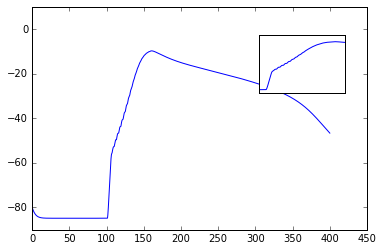

In [17]:


# max receptor current (uS). about same as total genesis activation (20)
# UPDATED********************************************************
stim.number     = 20
# ***************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
ax2 = plt.axes([.65, .6, .2, .2])
ax2.plot(tm,vm)
plt.setp(ax2, ylim=(-90, 0), xlim=(95,170), xticks=[], yticks=[])
plt.show()

## Add a somatic compartment

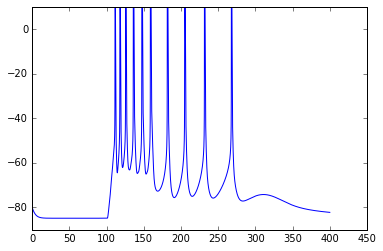

In [18]:



# UPDATED********************************************************
soma = h.Section(name='soma')

# size of soma
soma.L         = 12.2
soma(0.5).diam = 12.2

# insert pas
soma.insert('pas')
soma.g_pas = 1e-5
soma.e_pas = -80
soma.cm    = 1.0
soma.Ra    = 150

# insert ion channels
casc    =   h.D1_reduced_cascade2_0(0.5, sec=soma) 
pointer =   casc._ref_Target1p   

with open('params_dMSN.json') as file:
    par = json.load(file)

somaChan = [        "naf",
                    "kaf",
                    "kas",
                    "kdr",
                    "kir",
                    "cal12",
                    "cal13",
                    "can",
                    "car",
                    "sk",
                    "bk"        ]

for mech in somaChan:
    soma.insert(mech)

dist = 115.0

cmd = 'soma(0.5).gbar_naf = float(par["gbar_naf_somatic"]["Value"])'
exec(cmd)
cmd = 'soma(0.5).gbar_kaf = float(par["gbar_kaf_somatic"]["Value"])'
exec(cmd)   
cmd = 'soma(0.5).gbar_kas = float(par["gbar_kas_somatic"]["Value"])'
exec(cmd) 
cmd = 'soma(0.5).gbar_kir = float(par["gbar_kir_somatic"]["Value"])'
exec(cmd) 
cmd = 'soma(0.5).gbar_sk = float(par["gbar_sk_somatic"]["Value"])'
exec(cmd)
cmd = 'soma(0.5).gbar_bk = float(par["gbar_bk_somatic"]["Value"])'
exec(cmd)
cmd = 'soma(0.5).pbar_cal12 = 1e-5'
exec(cmd)
cmd = 'soma(0.5).pbar_cal13 = 1e-6'
exec(cmd)
cmd = 'soma(0.5).pbar_car = 1e-4'
exec(cmd)
cmd = 'soma(0.5).pbar_can = 1e-7'
    
    
for seg in soma:
    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:
            
            h.setpointer( pointer, 'pka', mech )


soma.ek  = -85.0
soma.ena  = 50.0

# connect the two compartments ------------------
dend.connect(soma(1))

# ***********************************************************************************

h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Resize dendritc compartment and add a few more segments

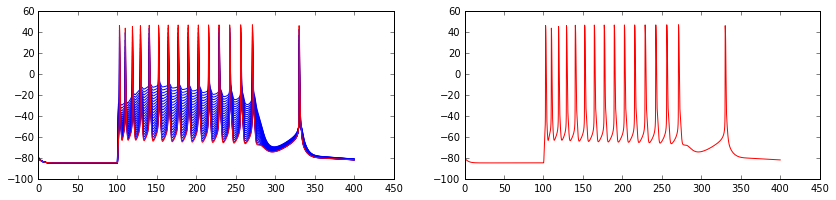

In [19]:

dend.L         = 230
dend.diam      = 1
dend.nseg      = 41
x              = 0.5
    
# insert pas
# dend.insert('pas')
# dend.g_pas = gpas
# dend.e_pas = Erev
# dend.cm    = Cm
# dend.Ra    = Ra

h.distance(sec=soma)
    
for mech in somaChan+["cav32", "cav33"]:
    dend.insert(mech)
    
# Set conductance and pointers (needed for dynamic neuromodulation; not used here).
for seg in dend:
    
    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:

            h.setpointer( pointer, 'pka', mech )
    
    dist = h.distance(seg.x, sec=dend)

    cmd = 'dend(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
    exec(cmd)
    cmd = 'dend(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
    exec(cmd)   
    cmd = 'dend(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
    exec(cmd) 
    cmd = 'dend(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
    exec(cmd) 
    cmd = 'dend(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
    exec(cmd)
    cmd = 'dend(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cal12 = 1e-5'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cal13 = 1e-6'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_car = 1e-4'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_can = 1e-7'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
    exec(cmd)




# max receptor current (uS)
ampa_max = 20e-3 
nmda_max = 60e-3 

# insert receptors (activated after 100 ms)
ampa       = h.ampa(x, sec=dend)
ampa.onset = 100
ampa.gmax  = ampa_max
nmda       = h.nmda(x, sec=dend)
nmda.onset = 100
nmda.gmax  = nmda_max



# record vectors
vm = h.Vector()
vm.record(soma(0.5)._ref_v)
vmL = {}
for seg in dend:
    if seg.x > x:
        break
    vmL[seg.x] = h.Vector()
    vmL[seg.x].record(dend(seg.x)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
fig, ax = plt.subplots(1,2, figsize=(14,3))
for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
for i in [0,1]:
    ax[i].plot(tm,vm, 'r')

plt.show()

### Since spiking; Not enough sink in soma -> add sink neurite

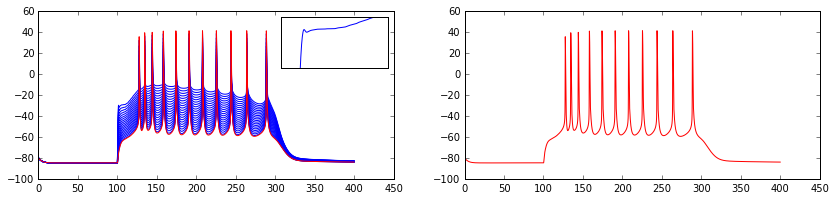

In [22]:

sink = h.Section(name='sink')
sink.connect(soma(1))

sink.L         = 230
sink.diam      = 3


# insert pas
sink.insert('pas')
sink.g_pas = 1e-5
sink.e_pas = -80
sink.cm    = 1.0
sink.Ra    = 150
        
for mech in somaChan+["cav32", "cav33"]:
    sink.insert(mech)
    
sink.ek  = -85
sink.ena =  50
    
# set pointers
for seg in sink:

    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:

            h.setpointer( pointer, 'pka', mech )
    
    dist = h.distance(seg.x, sec=sink)
    
    cmd = 'sink(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
    exec(cmd)   
    cmd = 'sink(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal12 = 1e-5'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal13 = 1e-6'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_car = 1e-4'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_can = 1e-7'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
    exec(cmd)




h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
fig, ax = plt.subplots(1,2, figsize=(14,3))

for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
    xL = seg.x
for i in [0,1]:
    ax[i].plot(tm,vm, 'r')
    
inset_ax = inset_axes(ax[0],
                      height="30%", 
                      width="30%", 
                      loc=1) 
inset_ax.plot(tm, vmL[xL], color='b')
plt.setp(inset_ax, ylim=(-60, -20), xlim=(95,125), xticks=[], yticks=[])

plt.show()


### Increasing diameter of sink (surface area)

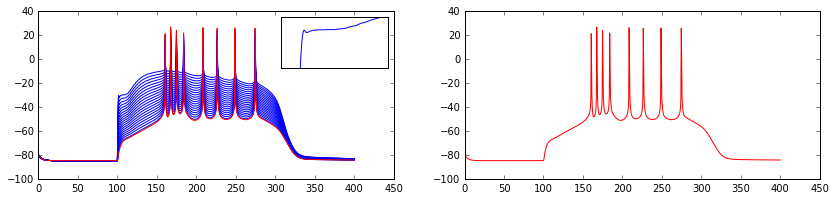

In [28]:

sink = h.Section(name='sink')
sink.connect(soma(1))

sink.L         = 230
sink.diam      = 5


# insert pas
sink.insert('pas')
sink.g_pas = 1e-5
sink.e_pas = -80
sink.cm    = 1.0
sink.Ra    = 150
        
for mech in somaChan+["cav32", "cav33"]:
    sink.insert(mech)
    
# set pointers
for seg in sink:

    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:

            h.setpointer( pointer, 'pka', mech )

sink.ek  = -85
sink.ena =  50
    



for seg in sink:
    
    dist = h.distance(seg.x, sec=sink)
    
    cmd = 'sink(seg.x).gbar_naf = 1e-5*calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
    exec(cmd)   
    cmd = 'sink(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal12 = 1e-8'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal13 = 1e-8'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_car = 1e-8'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_can = 1e-8'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav32 = 1e-3*calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav33 = 1e-3*calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
    exec(cmd)






h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
fig, ax = plt.subplots(1,2, figsize=(14,3))

for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
    xL = seg.x
for i in [0,1]:
    ax[i].plot(tm,vm, 'r')

inset_ax = inset_axes(ax[0],
                      height="30%", # 
                      width="30%", 
                      loc=1) 
inset_ax.plot(tm, vmL[xL], color='b')
plt.setp(inset_ax, ylim=(-60, -20), xlim=(95,125), xticks=[], yticks=[])
plt.show()


In [ ]:

# Cell class, similar to neuron ball-and-stick example
#             https://www.neuron.yale.edu/neuron/static/docs/neuronpython/ballandstick2.html
#             and Lindroos et al., 2018
class cell():
    
    def __init__(self, 
                 parameters={   'soma':{'L':12.2, 'diam':12.2, 'nseg':1}, 
                                'dend':{'L':12.2, 'diam':12.2, 'nseg':1}, 
                                'pas' :{'Ra':150, 'Cm':1, 'Erev':-80, 'gpas':1e-5}
                             }, 
                 params='params_dMSN.json'
                ):
        
        self.somaChan = [       "naf",
                                "kaf",
                                "kas",
                                "kdr",
                                "kir",
                                "cal12",
                                "cal13",
                                "can",
                                "car",
                                "sk",
                                "bk"        ]

            
        # create soma
        self.soma = h.Section(name='soma')
        self.dend = h.Section(name='dend')

        # connect the two sections
        self.dend.connect(self.soma(1))

        # size and number of segments of compartments
        self.soma.L         = parameters['soma']['L']
        self.soma(0.5).diam = parameters['soma']['diam']
        self.soma.nseg      = parameters['soma']['nseg']

        self.dend.L         = parameters['dend']['L']
        self.dend(0.5).diam = parameters['dend']['diam']
        self.dend.nseg      = parameters['soma']['nseg']

        # Axial resistance etc
        self.Ra   = parameters['pas']['Ra']
        self.Cm   = parameters['pas']['Cm']
        self.Erev = parameters['pas']['Erev']
        self.gpas = parameters['pas']['gpas']
        
        
        if 'Sink' in parameters:
            add_Sink_node(self,
                          parameters['Sink']
                         )

        # insert mechanisms (ion channels etc)
        casc    =   h.D1_reduced_cascade2_0(0.5, sec=self.dend) 
        pointer =   casc._ref_Target1p   


        with open(params) as file:
            par = json.load(file)


        for sec in h.allsec():    

            # insert pas
            sec.insert('pas')
            sec.g_pas = parameters['pas']['gpas']
            sec.e_pas = parameters['pas']['Erev']
            sec.cm    = parameters['pas']['Cm']
            sec.Ra    = parameters['pas']['Ra']

            # Set conductance and pointers (needed for dynamic neuromodulation; not used here).
            for seg in sec:

                # set conductance
                if sec.name() == 'soma':
                    for mech in somaChan:
                        sec.insert(mech)

                elif sec.name() in ['dend', 'Sink']:
                    for mech in somaChan+["cav32", "cav33"]:
                        sec.insert(mech)

                for mech in seg:
                    if mech.name() in [ "kaf", \
                                        "kv4", \
                                        "kas", \
                                        "naf", \
                                        "kir", \
                                        "cal12", \
                                        "cal13", \
                                        "can"           ]:

                        h.setpointer( pointer, 'pka', mech )
            
            sec.ek  = -85
            sec.ena =  50
            
        set_conductance(self, 
                        par
                       ):
    
    def set_conductance(self, 
                        parameters,
                        par
                       ):
    
        cmd = 'self.soma(0.5).gbar_naf = float(par["gbar_naf_somatic"]["Value"])'
        exec(cmd)
        cmd = 'self.soma(0.5).gbar_kaf = float(par["gbar_kaf_somatic"]["Value"])'
        exec(cmd)   
        cmd = 'soma(0.5).gbar_kas = float(par["gbar_kas_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'soma(0.5).gbar_kir = float(par["gbar_kir_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'soma(0.5).gbar_sk = float(par["gbar_sk_somatic"]["Value"])'
        exec(cmd)
        cmd = 'soma(0.5).gbar_bk = float(par["gbar_bk_somatic"]["Value"])'
        exec(cmd)
        cmd = 'soma(0.5).pbar_cal12 = 1e-5'
        exec(cmd)
        cmd = 'soma(0.5).pbar_cal13 = 1e-6'
        exec(cmd)
        cmd = 'soma(0.5).pbar_car = 1e-4'
        exec(cmd)
        cmd = 'soma(0.5).pbar_can = 1e-7'

        dist = 115.0
        for seg in self.dend:
    
            dist = h.distance(seg.x, sec=dend)

            cmd = 'dend(seg.x).gbar_naf = 0.000001*calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
            exec(cmd)
            cmd = 'dend(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
            exec(cmd)   
            cmd = 'dend(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
            exec(cmd) 
            cmd = 'dend(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
            exec(cmd) 
            cmd = 'dend(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
            exec(cmd)
            cmd = 'dend(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cal12 = 1e-5'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cal13 = 1e-6'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_car = 1e-4'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_can = 1e-10'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
            exec(cmd)
        
        
        if 'Sink' in parameters:
            
    
    def add_Sink_node(self,
                      Sinkpar
                     ):
        
        # create Sink node
        
        # specify properties
        
        # set conductances
        for seg in Sink:
    
            dist = h.distance(0.5, sec=Sink)

            cmd = 'Sink(0.5).gbar_naf = 0.0001* calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
            exec(cmd)
            cmd = 'Sink(0.5).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
            exec(cmd)   
            cmd = 'Sink(0.5).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
            exec(cmd) 
            cmd = 'Sink(0.5).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
            exec(cmd) 
            cmd = 'Sink(0.5).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
            exec(cmd)
            cmd = 'Sink(0.5).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cal12 = 1e-5'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cal13 = 1e-6'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_car = 1e-4'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_can = 1e-7'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
            exec(cmd)
        

    def set_synpatic():

        # max receptor current (uS)
        ampa_max = 10e-3 
        nmda_max = 30e-3 

        # insert receptors (activated after 100 ms)
        ampa       = h.ampa(0.5, sec=dend)
        ampa.onset = 100
        ampa.gmax  = ampa_max
        nmda       = h.nmda(0.5, sec=dend)
        nmda.onset = 100
        nmda.gmax  = nmda_max


# create cell
'''

# record vectors
vm = h.Vector()
vm.record(dend(0.5)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)



h.finitialize(-80)
while h.t < 500:
    h.fadvance()
    
plt.plot(tm,vm)
plt.show()'''